In [45]:
!pip install numpy matplotlib pandas tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Huawei\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [46]:
import json

import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import ticker

In [47]:
with open("bench.json", encoding="utf-8") as f:
    data = json.load(f)

pd.set_option('display.max_rows', 5)

data = [{**v, **v["tests"][0]} for v in data]
for v in data:
    del v["tests"]
    if "mnk" in v:
        v["mnk"] = v["mnk"][0]

data_df = pd.DataFrame(data)
data_df.sort_values(by="gflops", ascending=False)

gemm_data_df = data_df[data_df["mnk"].notnull()]
dot_data_df = data_df[data_df["n"].notnull()]

In [48]:
dot_data_cpu = dot_data_df[dot_data_df["runtime"].isin(["OpenMP", "OpenBLAS"])]
dot_data_cpu_float = dot_data_cpu[dot_data_cpu["dtype"] == "float"]
dot_data_cpu_double = dot_data_cpu[dot_data_cpu["dtype"] == "double"]
dot_data_cpu_float.sort_values(by="gflops", ascending=False)

,cpu,dtype,n,range,seed,gflops,result,runtime,version,block_size,gpu,grid_size,mnk
185,AMD Ryzen 9 3900X 12-Core Processor,float,500000000.0,"[-1.0, 1.0]",42,4.294561,163552400.0,OpenBLAS,OpenBLAS 0.3.29,NaN,NaN,NaN,NaN
186,AMD Ryzen 9 3900X 12-Core Processor,float,500000000.0,"[-1.0, 1.0]",42,4.288253,163552400.0,OpenBLAS,OpenBLAS 0.3.29,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,AMD Ryzen 9 3900X 12-Core Processor,float,100000000.0,"[-1.0, 1.0]",42,3.545791,33231448.0,OpenMP,4.5,NaN,NaN,NaN,NaN
22,AMD Ryzen 9 3900X 12-Core Processor,float,100000000.0,"[-1.0, 1.0]",42,3.110570,33276884.0,OpenBLAS,OpenBLAS 0.3.29,NaN,NaN,NaN,NaN


In [49]:
gemm_data_cpu = gemm_data_df[gemm_data_df["runtime"].isin(["OpenMP", "OpenBLAS"])]
gemm_data_cpu_float = gemm_data_cpu[gemm_data_cpu["dtype"] == "float"]
gemm_data_cpu_double = gemm_data_cpu[gemm_data_cpu["dtype"] == "double"]
gemm_data_cpu_float.sort_values(by="gflops", ascending=False)

,cpu,dtype,n,range,seed,gflops,result,runtime,version,block_size,gpu,grid_size,mnk
729,NaN,float,NaN,"[-1.0, 1.0]",42,4.398389,-36.645473,OpenMP,NaN,NaN,NaN,NaN,32.0
721,NaN,float,NaN,"[-1.0, 1.0]",42,4.369067,-36.645473,OpenMP,NaN,NaN,NaN,NaN,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,NaN,float,NaN,"[-1.0, 1.0]",42,0.339247,-17401.222656,OpenMP,NaN,NaN,NaN,NaN,1024.0
920,NaN,float,NaN,"[-1.0, 1.0]",42,0.338976,-17401.222656,OpenMP,NaN,NaN,NaN,NaN,1024.0


In [50]:
dot_data_gpu = dot_data_df[dot_data_df["runtime"].isin(["OpenCL", "CUDA", "cuBLAS", "CLBlast"])]
dot_data_gpu_float = dot_data_gpu[dot_data_gpu["dtype"] == "float"]
dot_data_gpu_double = dot_data_gpu[dot_data_gpu["dtype"] == "double"]
dot_data_gpu_float.sort_values(by="gflops", ascending=False)

,cpu,dtype,n,range,seed,gflops,result,runtime,version,block_size,gpu,grid_size,mnk
689,AMD Ryzen 9 3900X 12-Core Processor,float,600000000.0,"[-1.0, 1.0]",42,74.180763,199986448.0,CUDA,NaN,1024.0,NVIDIA GeForce RTX 2060,32768.0,NaN
483,AMD Ryzen 9 3900X 12-Core Processor,float,400000000.0,"[-1.0, 1.0]",42,73.851151,133325352.0,OpenCL,OpenCL 3.0 CUDA,1024.0,NVIDIA GeForce RTX 2060,32768.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,AMD Ryzen 9 3900X 12-Core Processor,float,100000000.0,"[-1.0, 1.0]",42,7.942559,33329568.0,cuBLAS,NaN,NaN,NVIDIA GeForce RTX 2060,NaN,NaN
307,AMD Ryzen 9 3900X 12-Core Processor,float,100000000.0,"[-1.0, 1.0]",42,7.625002,33329568.0,cuBLAS,NaN,NaN,NVIDIA GeForce RTX 2060,NaN,NaN


In [51]:
gemm_data_gpu = gemm_data_df[gemm_data_df["runtime"].isin(["OpenCL", "CUDA", "cuBLAS", "CLBlast"])]
gemm_data_gpu_float = gemm_data_gpu[gemm_data_gpu["dtype"] == "float"]
gemm_data_gpu_double = gemm_data_gpu[gemm_data_gpu["dtype"] == "double"]
gemm_data_gpu_float.sort_values(by="gflops", ascending=False)

,cpu,dtype,n,range,seed,gflops,result,runtime,version,block_size,gpu,grid_size,mnk
1429,NaN,float,NaN,"[-1.0, 1.0]",42,1623.603285,-1.802608e+05,CLBlast,NaN,NaN,NaN,NaN,8192.0
1424,NaN,float,NaN,"[-1.0, 1.0]",42,1613.937650,-1.802608e+05,CLBlast,NaN,NaN,NaN,NaN,8192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,AMD Ryzen 9 3900X 12-Core Processor,float,NaN,"[-1.0, 1.0]",42,0.000000,1.526643e+06,cuBLAS,NaN,NaN,NVIDIA GeForce RTX 2060,NaN,16384.0
1549,AMD Ryzen 9 3900X 12-Core Processor,float,NaN,"[-1.0, 1.0]",42,0.000000,1.526643e+06,cuBLAS,NaN,NaN,NVIDIA GeForce RTX 2060,NaN,16384.0


In [52]:

def plot_bench(data_df, xlabel="n", ylabel="gflops", xtitle="N", ytitle="GFLOPS", figsize=None):
    groups = data_df.groupby("runtime")
    
    fig, axes = plt.subplots(nrows=1, ncols=len(groups), figsize=figsize)

    for i, (runtime, group) in enumerate(groups):
        group = group.groupby(xlabel, as_index=False).mean(numeric_only=True)
        ax = axes[i]
        ax.plot(
            group[xlabel], 
            group[ylabel],
            marker="o",
            markersize=6,
            label=runtime,
        )
        ax.set_title(runtime)
        ax.set_xlabel(xtitle, labelpad=8)
        ax.set_ylabel(ytitle, labelpad=8)
        ax.set_xscale('log')
        ax.tick_params("x", rotation=90)
        ax.set_xticks(group[xlabel])
        # ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        # ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())

    plt.tight_layout()
    plt.show()

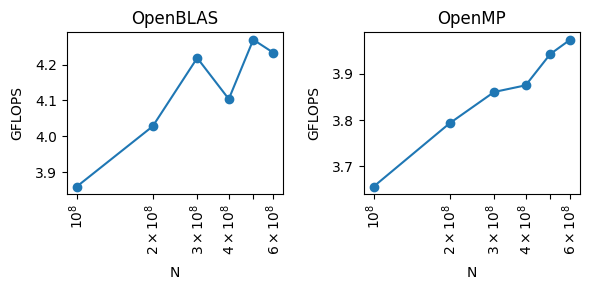

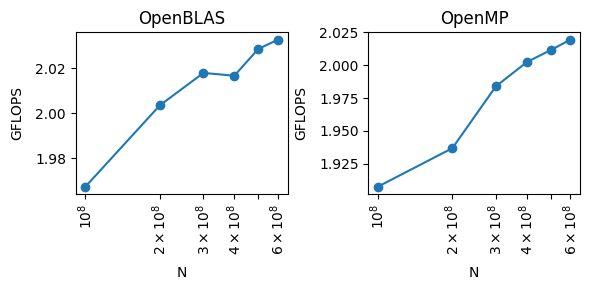

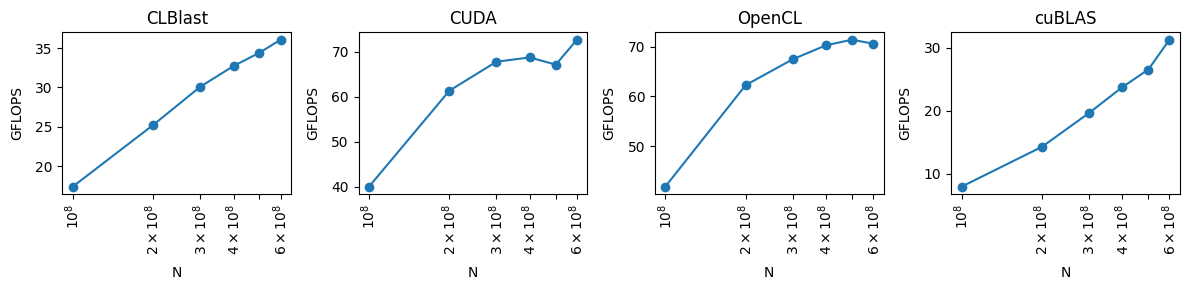

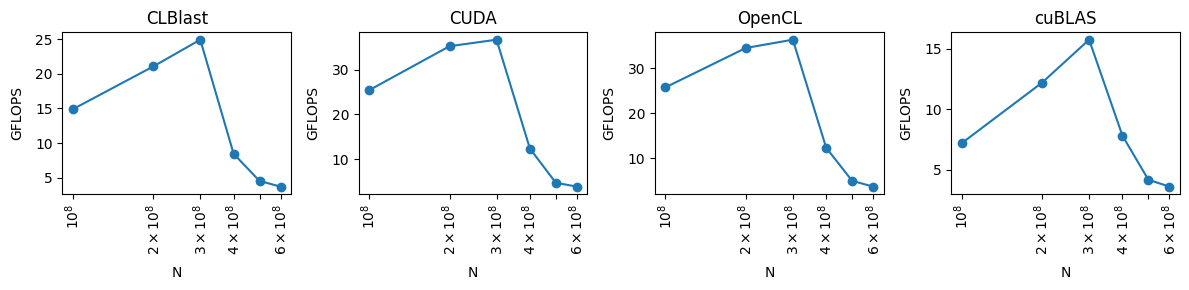

In [53]:
plot_bench(dot_data_cpu_float, figsize=(6, 3), xtitle="N", xlabel="n")
plot_bench(dot_data_cpu_double, figsize=(6, 3), xtitle="N", xlabel="n")

plot_bench(dot_data_gpu_float, figsize=(12, 3), xtitle="N", xlabel="n")
plot_bench(dot_data_gpu_double, figsize=(12, 3), xtitle="N", xlabel="n")

In [54]:

def plot_bench(data_df, xlabel="n", ylabel="gflops", xtitle="N", ytitle="GFLOPS", figsize=None):
    groups = data_df.groupby("runtime")
    
    fig, axes = plt.subplots(nrows=1, ncols=len(groups), figsize=figsize)

    for i, (runtime, group) in enumerate(groups):
        group = group.groupby(xlabel, as_index=False).mean(numeric_only=True)
        ax = axes[i]
        ax.plot(
            group[xlabel], 
            group[ylabel],
            marker="o",
            markersize=6,
            label=runtime,
        )
        ax.set_title(runtime)
        ax.set_xlabel(xtitle, labelpad=8)
        ax.set_ylabel(ytitle, labelpad=8)
        ax.tick_params("x", rotation=90)
        ax.set_xscale('log')
        ax.set_xticks(group[xlabel])
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())

    plt.tight_layout()
    plt.show()

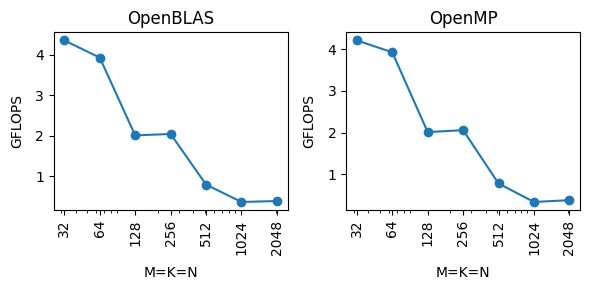

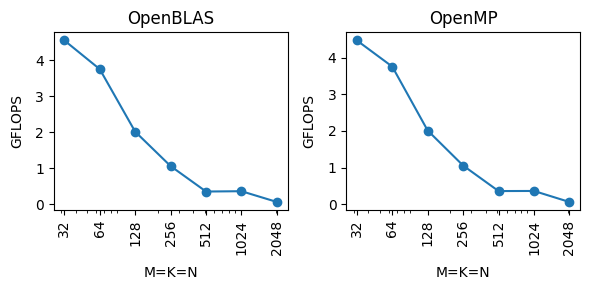

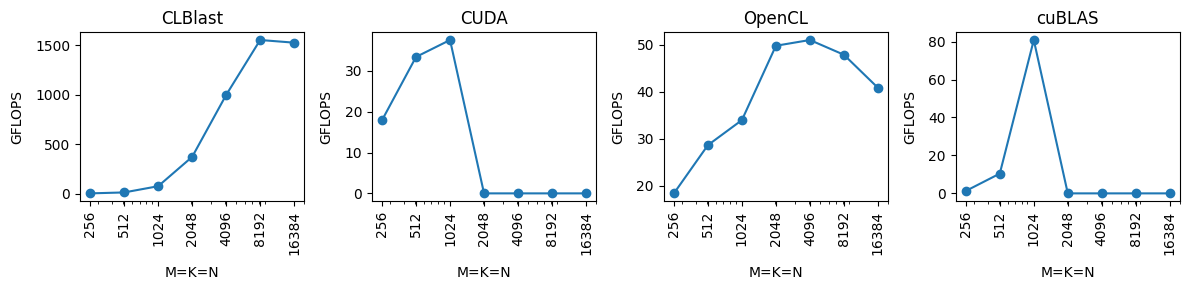

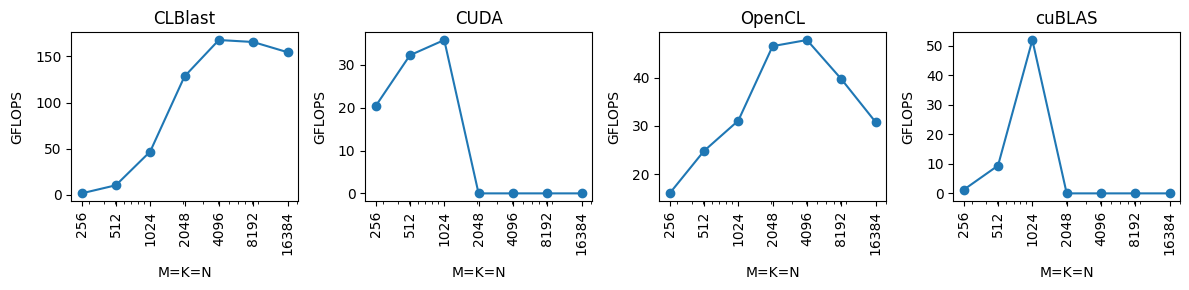

In [55]:
plot_bench(gemm_data_cpu_float, figsize=(6, 3), xtitle="M=K=N", xlabel="mnk")
plot_bench(gemm_data_cpu_double, figsize=(6, 3), xtitle="M=K=N", xlabel="mnk")

plot_bench(gemm_data_gpu_float, figsize=(12, 3), xtitle="M=K=N", xlabel="mnk")
plot_bench(gemm_data_gpu_double, figsize=(12, 3), xtitle="M=K=N", xlabel="mnk")